Create compression version of GPT-2 nad BERT model and save the memory =)

## cola example

The Semantic Textual Similarity Benchmark (Cer et al., 2017) is a collection of sentence pairs drawn from news headlines, video and image captions, and natural language inference data. Each pair is human-annotated with a similarity score from 0 to 5.

In [1]:
import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"


In [2]:
#!pip install Partial State

In [3]:
import transformers
print (transformers.__version__)

4.30.2


In [4]:
from sparse_grad import replace_bert_layers

In [5]:
def create_space_matrices(model):
    if hasattr(model, "bert") and hasattr(model.bert, "encoder"):
        encoder = model.bert.encoder
    elif hasattr(model, "encoder"):
        encoder = model.encoder
    else:
        raise ValueError("Expected model to have attribute 'encoder' or 'bert.encoder'.")

    for i, layer in enumerate(encoder.layer):
        
        layer.intermediate.dense.create_UV()
          
        layer.output.dense.create_UV()
          
        #print ("new shape", layer.output.dense.weight.shape)
        #print ("\n\n")

    return model

In [6]:
def sparse_grad_linear(model, *args):
    print ("create bert with sparse grads")
    model = replace_bert_layers(model)
    print ("created bert with sparse grads")
    return model

In [7]:
from datasets import load_dataset
import pandas as pd

dataset_cola_cut = load_dataset('glue', 'cola', split='train[:10%]')
dataset_cola_cut.num_rows

Found cached dataset glue (/root/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


855

In [8]:
dataset_cola_cut

Dataset({
    features: ['sentence', 'label', 'idx'],
    num_rows: 855
})

In [9]:
dataset_cola = load_dataset('glue', 'cola')
dataset_cola.num_rows

Found cached dataset glue (/root/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

{'train': 8551, 'validation': 1043, 'test': 1063}

In [10]:
label_list = dataset_cola["train"].features["label"].names
num_labels = len(label_list)


In [11]:
config

Available objects for config:
     AliasManager
     DisplayFormatter
     HistoryManager
     IPCompleter
     IPKernelApp
     InlineBackend
     LoggingMagics
     MagicsManager
     OSMagics
     PrefilterManager
     ScriptMagics
     StoreMagics
     ZMQInteractiveShell


In [12]:
set(pd.DataFrame(dataset_cola['train']).label)

{0, 1}

In [13]:
task_num_labels = num_labels

from transformers import AutoConfig, BertConfig, AutoModelForSequenceClassification, AutoTokenizer

path_name = r"bert-base-uncased"

config = AutoConfig.from_pretrained(
    path_name,
    num_labels=num_labels,
)

model = AutoModelForSequenceClassification.from_pretrained(
    path_name,
    config=config,
)

tokenizer = AutoTokenizer.from_pretrained(path_name)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [14]:
#model=model.to('cuda:2')

In [15]:
task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}
sentence1_key, sentence2_key = task_to_keys['cola']

In [16]:

def preprocess_function(examples):
        # Tokenize the texts
        args = (
            (examples[sentence1_key],) if sentence2_key is None else (examples[sentence1_key], examples[sentence2_key])
        )
        
        
        result = tokenizer.batch_encode_plus(*args, max_length=128, truncation=True, padding="max_length")

        result["label"] = examples["label"]
        return result

In [17]:
num_labels

2

In [18]:
dataset_cola['train']

Dataset({
    features: ['sentence', 'label', 'idx'],
    num_rows: 8551
})

In [19]:
tokenized_dataset_cut = dataset_cola_cut.map(
            preprocess_function,
            batched=True,
            load_from_cache_file=False
        )

  0%|          | 0/1 [00:00<?, ?ba/s]

In [20]:
tokenized_dataset = dataset_cola.map(
            preprocess_function,
            batched=True,
            load_from_cache_file=False
        )

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [21]:
tokenized_dataset['validation']

Dataset({
    features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1043
})

In [22]:
tokenized_dataset_cut

Dataset({
    features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 855
})

In [23]:
from torch.utils.data import DataLoader, RandomSampler

eval_dataloader = DataLoader(tokenized_dataset['validation'], batch_size=10)


In [24]:
type(tokenized_dataset)

datasets.dataset_dict.DatasetDict

In [25]:
from transformers import Trainer
import evaluate as ev
import numpy as np

from transformers import TrainingArguments, Trainer, EvalPrediction

2023-07-17 16:39:41.092485: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [26]:
metric = ev.load("glue", 'cola')

In [27]:
import numpy as np
import matplotlib.pyplot as plt

In [28]:
def compute_metrics(p: EvalPrediction):
        preds_ = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
        preds_ = np.argmax(preds_, axis=1)
        
        result = metric.compute(predictions=preds_, references=p.label_ids)
        if True:
            result["combined_score"] = np.mean(list(result.values())).item()
            return result
        else:
            return {"accuracy": (preds_ == p.label_ids).astype(np.float32).mean().item()}

In [29]:
training_args = TrainingArguments(
    learning_rate=2e-5,
    num_train_epochs=15,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=128,
    save_steps=100,
    eval_steps=100,
    output_dir="./bert_stsb_128",
    overwrite_output_dir=True,
    # The next line is important to ensure the dataset labels are properly passed to the model
    remove_unused_columns=True,
    seed=297104,
    report_to='none',
    )

In [30]:
import torch 
class TrainerBert(Trainer):
    
    def make_grad_bank(self):
        self.n_show = 10
        self.losses = []
    
    def training_step(self, model, inputs):
        model.train()
        inputs = self._prepare_inputs(inputs)
        with self.compute_loss_context_manager():
            loss = self.compute_loss(model, inputs)
        loss.backward()
        for layer in range(12):
                
            if (len(model.bert.encoder.layer[layer].output.dense.grads)) < 31:
                model.bert.encoder.layer[layer].output.dense.grads.append(model.bert.encoder.layer[layer].output.dense.weight.grad)

            if (len(model.bert.encoder.layer[layer].intermediate.dense.grads)) < 31:
                model.bert.encoder.layer[layer].intermediate.dense.grads.append(model.bert.encoder.layer[layer].intermediate.dense.weight.grad)
                

            else:
                if (self.n_show > 0):
                    self.n_show -= 1
                    im= plt.imshow(model.bert.encoder.layer[layer].output.dense.weight.grad[:50, :50].cpu().detach().numpy(), cmap='jet', aspect='auto')#not in spy
                    print ("number of nonzero ", torch.count_nonzero(model.bert.encoder.layer[layer].output.dense.weight.grad.cpu().detach()))
                    plt.title('grad '+'20x20 ' + str(self.n_show)) 
                    plt.colorbar(im) #not in spy
                    plt.show()

                    im= plt.imshow(model.bert.encoder.layer[layer].intermediate.dense.weight.grad[:50, :50].cpu().detach().numpy(), cmap='jet', aspect='auto')#not in spy
                    print ("number of nonzero ", torch.count_nonzero(model.bert.encoder.layer[layer].intermediate.dense.weight.grad.cpu().detach()))
                    plt.title('grad '+'20x20 ' + str(self.n_show)) 
                    plt.colorbar(im) #not in spy
                    plt.show()
                
                    
        
        

        self.losses.append(loss.cpu().detach().numpy())
        return loss.detach()

In [31]:
model = sparse_grad_linear(model)

create bert with sparse grads
created bert with sparse grads


In [32]:
trainer = TrainerBert(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        #train_dataset = tokenized_dataset_cut,
        eval_dataset=tokenized_dataset["validation"],
)
trainer.make_grad_bank()

In [33]:
#trainer = Trainer(
#        model=model,
#        args=training_args,
#        train_dataset=tokenized_dataset["train"],
#        #train_dataset = tokenized_dataset_cut,
#        eval_dataset=tokenized_dataset["validation"],
#)

In [34]:
trainer.train_dataset

Dataset({
    features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 8551
})

len small dataset 8551
lets collect gradients


/opt/.pyenv/versions/3.8.10/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.513500
1000,0.371600
1500,0.276300
2000,0.211100
2500,0.176400
3000,0.141300


created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
number of nonzero  tensor(2359296)


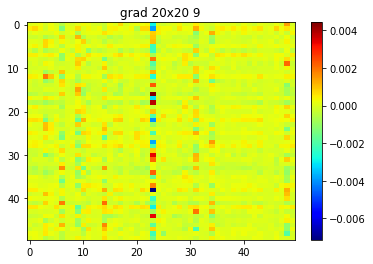

number of nonzero  tensor(2359296)


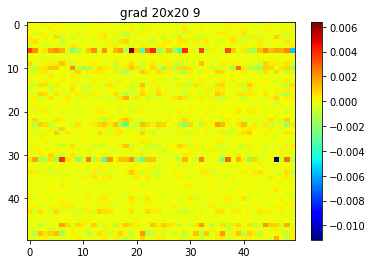

number of nonzero  tensor(2359296)


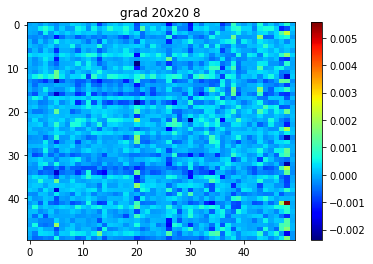

number of nonzero  tensor(2359296)


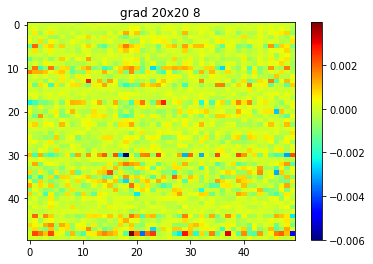

number of nonzero  tensor(2359296)


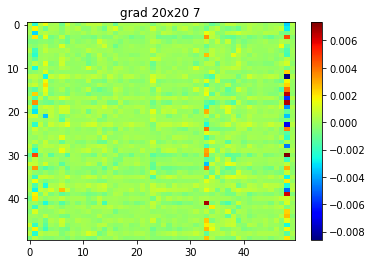

number of nonzero  tensor(2359296)


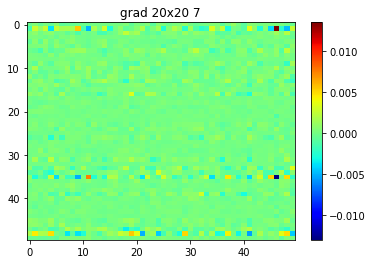

number of nonzero  tensor(2359296)


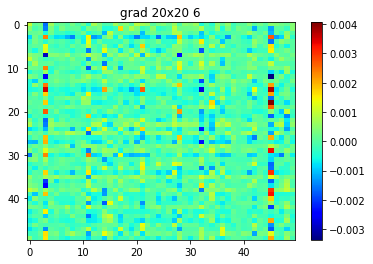

number of nonzero  tensor(2359296)


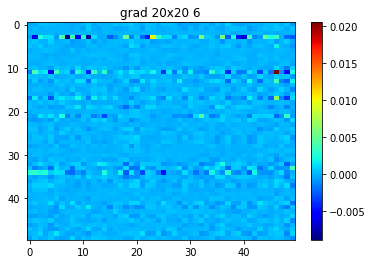

number of nonzero  tensor(2359296)


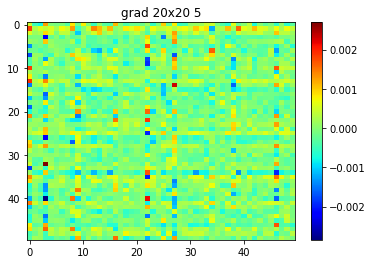

number of nonzero  tensor(2359296)


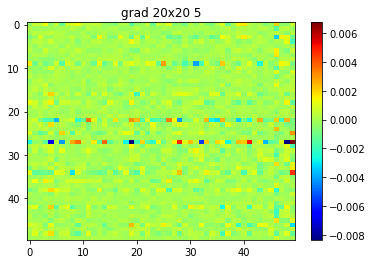

number of nonzero  tensor(2359296)


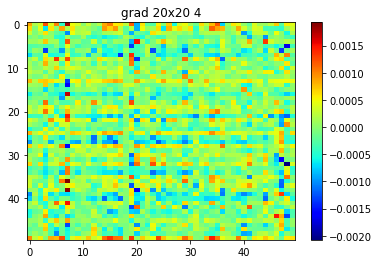

number of nonzero  tensor(2359296)


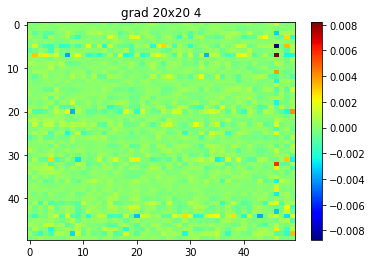

number of nonzero  tensor(2359296)


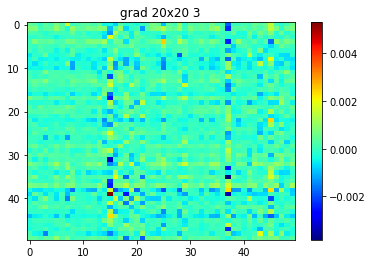

number of nonzero  tensor(2359296)


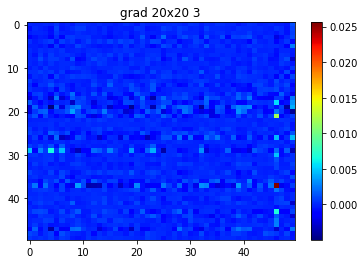

number of nonzero  tensor(2359296)


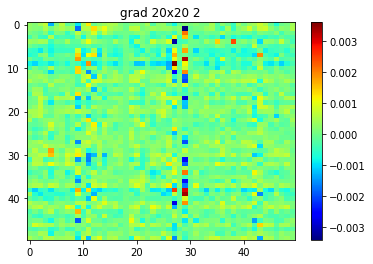

number of nonzero  tensor(2359296)


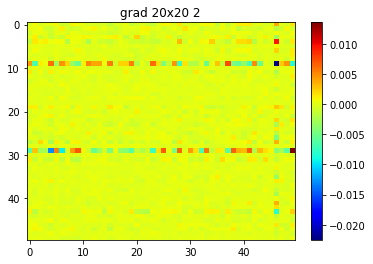

number of nonzero  tensor(2359296)


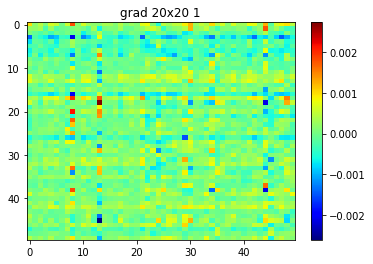

number of nonzero  tensor(2359296)


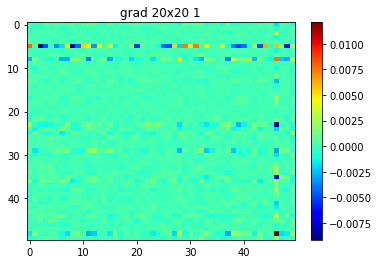

number of nonzero  tensor(2359296)


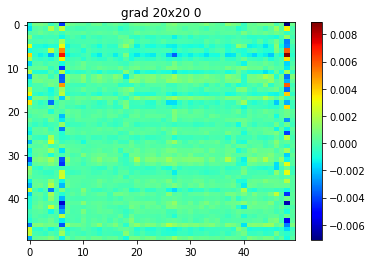

number of nonzero  tensor(2359296)


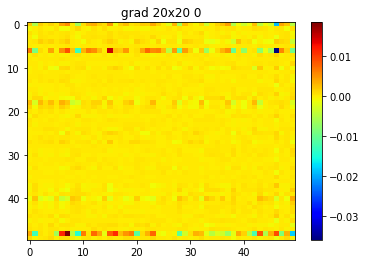

In [ ]:

print ("len small dataset", len(trainer.train_dataset))
print ("lets collect gradients")
train_result = trainer.train()
print ("finishing collecting gradients")
#model = create_space_matrices(model)

In [ ]:
print ("len small dataset", len(trainer.train_dataset))
print ("lets collect gradients")
train_result = trainer.train()
print ("finishing collecting gradients")
#model = create_space_matrices(model)

## first variant

In [ ]:
plt.plot(np.mean(np.array(trainer.losses[:8000]).reshape(-1, 50), axis=1), label = "bert in new basi")
plt.plot(np.mean(old[:8000].reshape(-1, 50), axis=1), label = "regular bert")
plt.plot(np.mean(new[:8000].reshape(-1, 50), axis=1), label = "bert in new basis ~100*100")
plt.legend()

## second

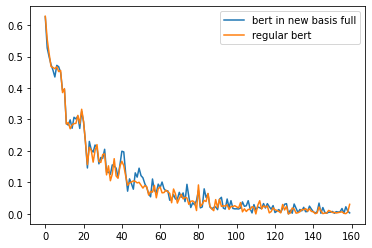

In [37]:
plt.plot(np.mean(np.array(trainer.losses[:8000]).reshape(-1, 50), axis=1), label = "bert in new basis full")
#plt.plot(np.mean(new[:8000].reshape(-1, 50), axis=1), label = "bert in new basis")
plt.plot(np.mean(old[:8000].reshape(-1, 50), axis=1), label = "regular bert")
plt.legend()

In [38]:
import pickle

with open('new_basis_0001.pickle', 'wb') as handle:
    pickle.dump(np.array(trainer.losses), handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import pickle
old  = pickle.load( open( "./full_bert.pickle", "rb" ) ) 
new = pickle.load( open( "./new_basis_0001.pickle", "rb" ) )

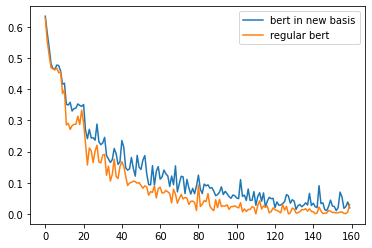

In [49]:
plt.plot(np.mean(new[:8000].reshape(-1, 50), axis=1), label = "bert in new basis")
plt.plot(np.mean(old[:8000].reshape(-1, 50), axis=1), label = "regular bert")
plt.legend()

In [34]:
import pickle
sparse001 = pickle.load( open( "./trh_001.pickle", "rb" ) ) 
non_sparse = pickle.load( open( "./no_trh.pickle", "rb" ) ) 
sparse0001 = pickle.load( open( "./trh_0001.pickle", "rb" ) ) 

In [40]:
len(sparse001)

48

In [ ]:
np.mean(np.array(sparse001).reshape(-1, 4))

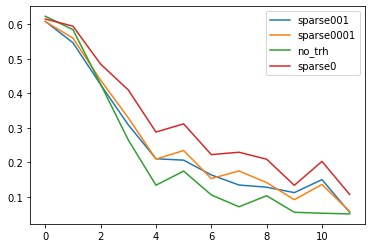

In [37]:
import matplotlib.pyplot as plt

plt.plot(np.mean(np.array(sparse001).reshape(-1, 4), axis=1), label='sparse001')
plt.plot(np.mean(np.array(sparse0001).reshape(-1, 4), axis=1), label='sparse0001')
plt.plot(np.mean(np.array(non_sparse).reshape(-1, 4), axis=1), label='no_trh')
plt.plot(np.mean(np.array(trainer.losses[:480]).reshape(-1, 40), axis=1), label='sparse0')
plt.legend()
plt.show()

In [37]:
import pickle

with open('trh_001.pickle', 'wb') as handle:
    pickle.dump(np.mean(np.array(trainer.losses[:480]).reshape(-1, 10), axis=1), handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
## trh 0.0001

len small dataset 855
lets collect gradients


Step,Training Loss
500,0.253800


created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix
created matrix


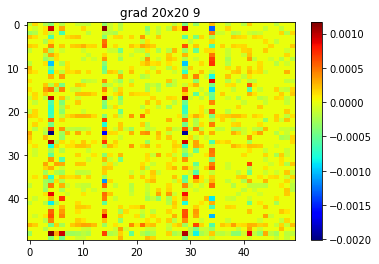

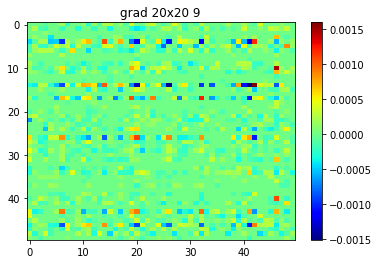

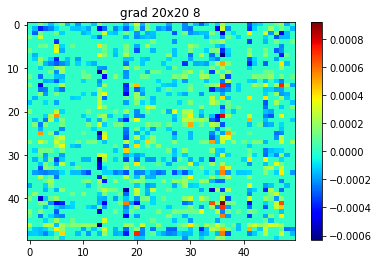

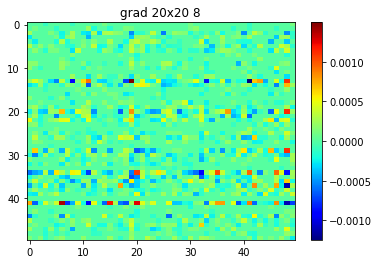

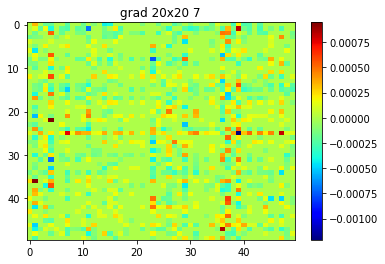

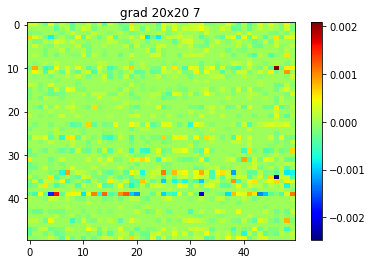

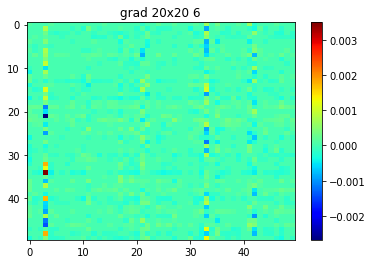

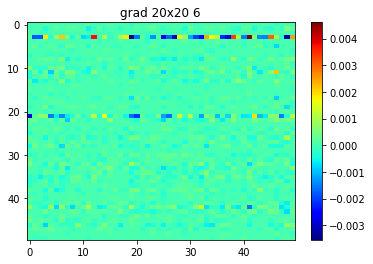

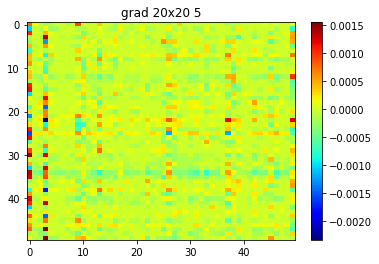

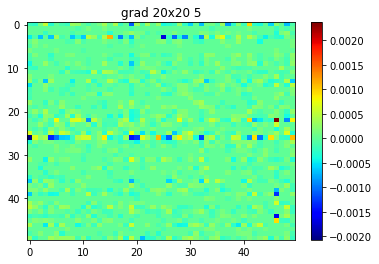

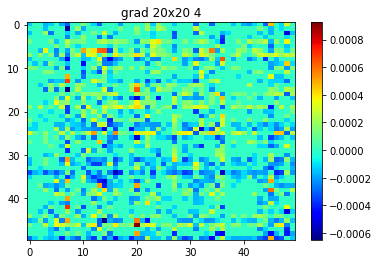

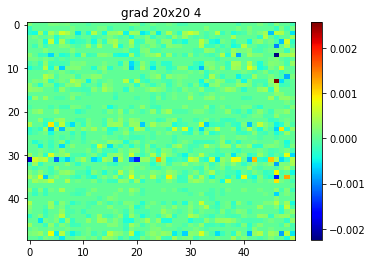

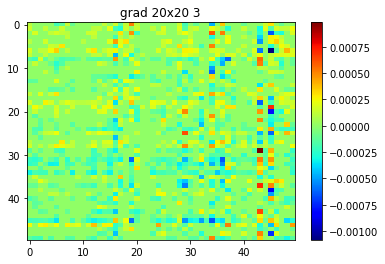

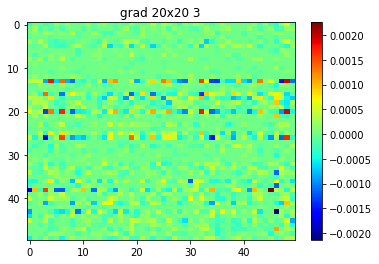

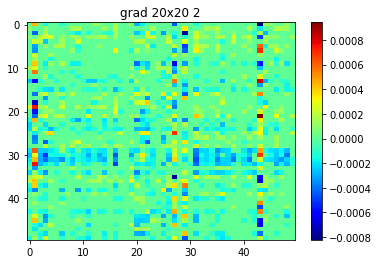

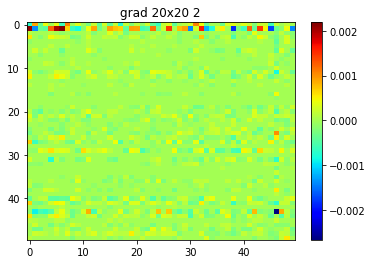

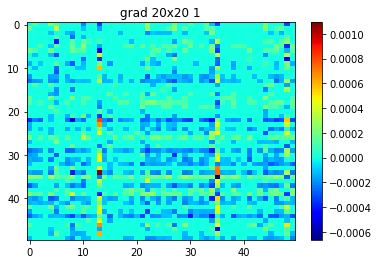

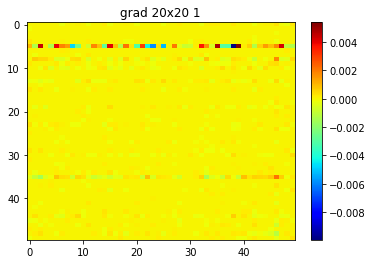

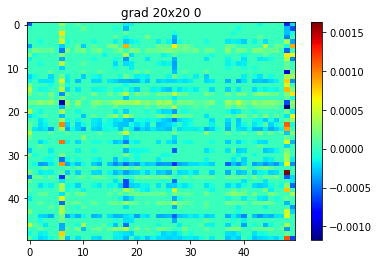

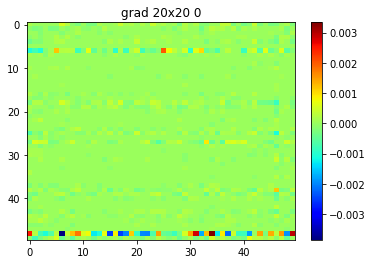

finishing collecting gradients


In [35]:
print ("len small dataset", len(trainer.train_dataset))
print ("lets collect gradients")
train_result = trainer.train()
print ("finishing collecting gradients")
#model = create_space_matrices(model)

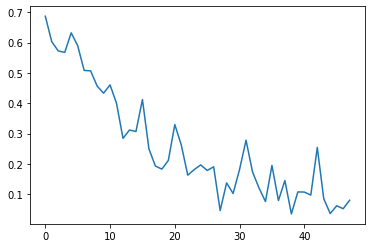

In [36]:
plt.plot(np.mean(np.array(trainer.losses[:480]).reshape(-1, 10), axis=1))

In [37]:
import pickle

with open('trh_0001.pickle', 'wb') as handle:
    pickle.dump(np.mean(np.array(trainer.losses[:480]).reshape(-1, 10), axis=1), handle, protocol=pickle.HIGHEST_PROTOCOL)

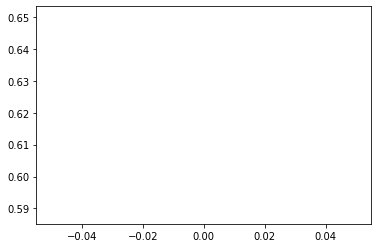

In [39]:
import matplotlib.pyplot as plt
plt.plot(np.mean(np.array(trainer.losses[:1600])), label='tr = 0.001')

In [37]:
trainer.args._n_gpu=1

In [38]:
type(model)

transformers.models.bert.modeling_bert.BertForSequenceClassification

In [39]:
trainer.train()

Step,Training Loss


TrainOutput(global_step=54, training_loss=0.8173975061487269, metrics={'train_runtime': 7.4934, 'train_samples_per_second': 114.1, 'train_steps_per_second': 7.206, 'total_flos': 56239988083200.0, 'train_loss': 0.8173975061487269, 'epoch': 1.0})

In [40]:
len(trainer.losses)

108

In [ ]:
trainer.evaluate()

In [ ]:
len(sparse)

In [ ]:
np.mean(np.array(sparse0001[:1600]).reshape(-1, 100), axis=1)

In [ ]:
len(np.mean(np.array(sparse[:1600]).reshape(-1, 100), axis=1))

In [ ]:
import matplotlib.pyplot as plt

plt.plot(np.mean(np.array(sparse001[:1600]).reshape(-1, 100), axis=1), label='tr = 0.01, c_rate = 0.00001')
plt.plot(np.mean(np.array(sparse0001[:1600]).reshape(-1, 100), axis=1), label='tr = 0.001, c_rate = 0.1')
plt.plot(np.mean(np.array(trainer.losses[:1600]).reshape(-1, 100), axis=1), label='topk500')
plt.plot(np.mean(np.array(sparse[:1600]).reshape(-1, 100), axis=1), label='topk100')
plt.plot(np.mean(np.array(sparse01[:1600]).reshape(-1, 100), axis=1), label='tr = 0.1')
plt.plot(np.mean(np.array(freeze[:1600]).reshape(-1, 100), axis=1), label='freeze dense layers')
plt.plot(np.mean(np.array(full[:1600]).reshape(-1, 100), axis=1), label='full unfreeze model')

plt.title("Loss curves")
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend()
plt.savefig("cola_trasholds_v3.png")
plt.show()

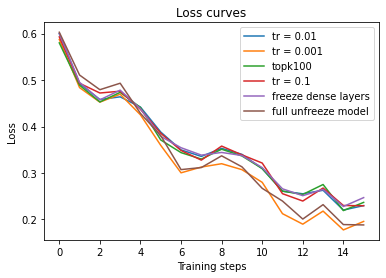

In [59]:
import matplotlib.pyplot as plt

plt.plot(np.mean(np.array(sparse001[:1600]).reshape(-1, 100), axis=1), label='tr = 0.01')
plt.plot(np.mean(np.array(trainer.losses[:1600]).reshape(-1, 100), axis=1), label='tr = 0.001')
plt.plot(np.mean(np.array(sparse[:1600]).reshape(-1, 100), axis=1), label='topk100')
plt.plot(np.mean(np.array(sparse01[:1600]).reshape(-1, 100), axis=1), label='tr = 0.1')
plt.plot(np.mean(np.array(freeze[:1600]).reshape(-1, 100), axis=1), label='freeze dense layers')
plt.plot(np.mean(np.array(full[:1600]).reshape(-1, 100), axis=1), label='full unfreeze model')

plt.title("Loss curves")
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend()
plt.savefig("cola_trasholds_v2.png")
plt.show()

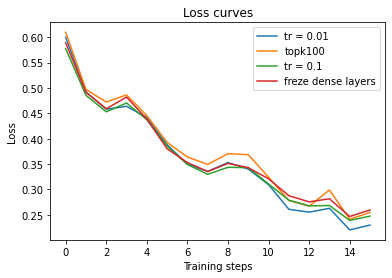

In [62]:
import matplotlib.pyplot as plt

plt.plot(np.mean(np.array(sparse001[:1600]).reshape(-1, 100), axis=1), label='tr = 0.01')
plt.plot(np.mean(np.array(trainer.losses[:1600]).reshape(-1, 100), axis=1), label='topk100')
plt.plot(np.mean(np.array(sparse01[:1600]).reshape(-1, 100), axis=1), label='tr = 0.1')
plt.plot(np.mean(np.array(freeze[:1600]).reshape(-1, 100), axis=1), label='freeze dense layers')
plt.plot(np.mean(np.array(full[:1600]).reshape(-1, 100), axis=1), label='full unfreeze model')

plt.title("Loss curves")
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend()
plt.savefig("cola_trasholds.png")
plt.show()

In [35]:
trainer.train()

/opt/.pyenv/versions/3.8.10/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.492100
1000,0.352500
1500,0.282500


TrainOutput(global_step=1605, training_loss=0.3686714778436679, metrics={'train_runtime': 246.9003, 'train_samples_per_second': 103.9, 'train_steps_per_second': 6.501, 'total_flos': 1687396975787520.0, 'train_loss': 0.3686714778436679, 'epoch': 3.0})

In [37]:
trainer.evaluate()

{'eval_loss': 0.5227116942405701,
 'eval_matthews_correlation': 0.5572696682585848,
 'eval_combined_score': 0.5572696682585848,
 'eval_runtime': 1.4878,
 'eval_samples_per_second': 701.024,
 'eval_steps_per_second': 6.049,
 'epoch': 3.0}

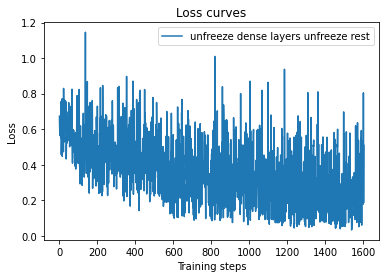

In [36]:
import matplotlib.pyplot as plt

plt.plot(trainer.losses, label='unfreeze dense layers unfreeze rest')

plt.title("Loss curves")
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend()
plt.savefig("cola_unfreeze_model.png")
plt.show()

In [46]:
trainer.train()

/opt/.pyenv/versions/3.8.10/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.486900
1000,0.303500
1500,0.199000


TrainOutput(global_step=1605, training_loss=0.31984966789079233, metrics={'train_runtime': 177.1132, 'train_samples_per_second': 144.84, 'train_steps_per_second': 9.062, 'total_flos': 1687396975787520.0, 'train_loss': 0.31984966789079233, 'epoch': 3.0})

In [56]:
trainer.evaluate()

{'eval_loss': 0.6566889882087708,
 'eval_matthews_correlation': 0.5804132033917235,
 'eval_combined_score': 0.5804132033917235,
 'eval_runtime': 1.4725,
 'eval_samples_per_second': 708.316,
 'eval_steps_per_second': 6.112}

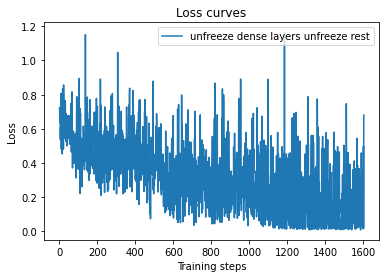

In [48]:
import matplotlib.pyplot as plt

plt.plot(trainer.losses, label='unfreeze dense layers unfreeze rest')

plt.title("Loss curves")
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend()
plt.savefig("cola_unfreeze_model.png")
plt.show()

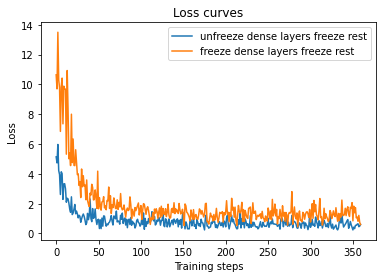

In [41]:
import matplotlib.pyplot as plt

plt.plot(trainer.losses, label='unfreeze dense layers freeze rest')
plt.plot(freeze, label='freeze dense layers freeze rest')
#plt.plot(freeze, label='freeze dense layers')
plt.title("Loss curves")
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend()
plt.savefig("freeze0.png")
plt.show()

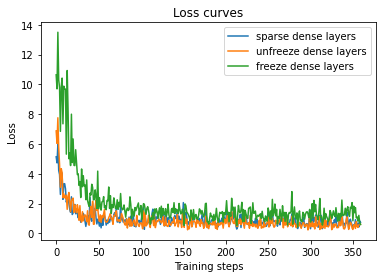

In [54]:
import matplotlib.pyplot as plt

plt.plot(trainer.losses, label='sparse dense layers')
plt.plot(full, label='unfreeze dense layers')
plt.plot(freeze, label='freeze dense layers')
plt.title("Loss curves")
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend()
plt.savefig("freeze0.png")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.plot(trainer.losses, label='all zeros')
plt.plot(full, label='full grads')
plt.title("Loss curves")
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
a = np.stack(trainer.grad_bank_out[4][:28], axis = 0)
print (a.shape)
a = np.moveaxis(a, 0, 2)
print (a.shape)

In [ ]:
len(dict_int[0][4])

In [ ]:
import torch
dict_int = get_tucker_tensors(trainer.grad_bank_int)
dict_out = get_tucker_tensors(trainer.grad_bank_out)
print (dict_int[0].shape)
print (dict_int[1].shape)
for i in range(1):
    u1_int, u2_int = Tucker_Decomposition(dict_int[i])
    u1_out, u2_out = Tucker_Decomposition(dict_out[i])

In [ ]:
for i in range(1):
    print(i)

In [ ]:
print (u1_int.shape, u2_int.shape)

In [ ]:
def func_collecting_tensors(step, tensor1, tensor2=None):
    if step == 0:
        return tensor1.unsqueeze(0)
    else:
        return torch.concatenate((tensor1, tensor2),0)
    
def Tucker_Decomposition(tensor):
    n1, n2, n3 = tensor.shape
    u1, s1, v1 = np.linalg.svd(np.reshape(tensor, (n1, -1)), full_matrices=False)
    u2, s1, v1 = np.linalg.svd(np.reshape(np.transpose(tensor,[1,2,0]), (n2, -1)), full_matrices=False)
    u3, s1, v1 = np.linalg.svd(np.reshape(np.transpose(tensor,[2,0,1]), (n3, -1)), full_matrices=False)
    return u1, u2

def get_tucker_tensors(dict_layers):
    '''
    делает словарь где ключом будет слой, а значением будет тензор
    '''
    dict_tensor = dict(zip(range(12), [None]*12))
    for key in dict_layers.keys():
        dict_tensor[key] = np.moveaxis(np.stack(dict_layers[key][:28], axis = 0), 0, 2)
    return dict_tensor
    

In [ ]:
u1_int.T.shape

In [ ]:
matrix.shape

In [ ]:
for ind, matrix in enumerate(trainer.grad_bank_int[0][26:]):
    print ("layer", 0, "batch", ind+26)
    matrix_in_basis = u1_int.T @ matrix @ u2_int
    im= plt.imshow(matrix_in_basis, cmap='jet', aspect='auto')#not in spy
    plt.title('GRAD WEIGHTS ') 
    plt.colorbar(im) #not in spy
    plt.show()

    im= plt.imshow(matrix_in_basis[:50, :50], cmap='jet', aspect='auto')#not in spy
    plt.title('GRAD WEIGHTS '+'20x20 ') 
    plt.colorbar(im) #not in spy
    plt.show()
    print('\n\n\n\n')

In [ ]:
for ind, matrix in enumerate(trainer.grad_bank_out[0][26:]):
    print ("layer", 0, "batch", ind+26)
    matrix_in_basis = u1_out.T @ matrix @ u2_out
    im= plt.imshow(matrix_in_basis, cmap='jet', aspect='auto')#not in spy
    plt.title('GRAD WEIGHTS ') 
    plt.colorbar(im) #not in spy
    plt.show()

    im= plt.imshow(matrix_in_basis[:50, :50], cmap='jet', aspect='auto')#not in spy
    plt.title('GRAD WEIGHTS '+'20x20 ') 
    plt.colorbar(im) #not in spy
    plt.show()
    print('\n\n\n\n')

In [ ]:
import pickle

with open('regular_grad_int.pcl', 'wb') as fp:
    pickle.dump(trainer.grad_bank_int, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('regular_grad_out.pcl', 'wb') as fp:
    pickle.dump(trainer.grad_bank_out, fp, protocol=pickle.HIGHEST_PROTOCOL)



In [ ]:
import pickle

with open('sparse_s.pcl', 'wb') as fp:
    pickle.dump(trainer.sparse_grad_bank_int, fp, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
with open('regular_grad_int.pcl', 'rb') as fp:
    data = pickle.load(fp)

In [28]:
len(data[2])

NameError: name 'data' is not defined

In [29]:
for layer in range(len(trainer.sparse_grad_bank_int)):
  for batch in range(len(trainer.sparse_grad_bank_int[layer])):
      S_hat_zero= trainer.sparse_grad_bank_int[layer][batch]
      print ("layer", layer, "batch", batch)
      im= plt.imshow(S_hat_zero, cmap='jet', aspect='auto')#not in spy
      plt.title('GRAD WEIGHTS ') 
      plt.colorbar(im) #not in spy
      plt.show()

      im= plt.imshow(S_hat_zero[:20, :20], cmap='jet', aspect='auto')#not in spy
      plt.title('GRAD WEIGHTS '+'20x20 ') 
      plt.colorbar(im) #not in spy
      plt.show()
      print('\n\n\n\n')

NameError: name 'trainer' is not defined

get proper gradients (3rd output 3 layer)

In [ ]:
trainer.grad_bank_out[3]

tensor([[ 0.0087,  0.0019,  0.0022,  ..., -0.0060, -0.0029, -0.0028],
        [-0.0242, -0.0136,  0.0077,  ...,  0.0116, -0.0138, -0.0200],
        [ 0.0011, -0.0008, -0.0025,  ...,  0.0030,  0.0122,  0.0007],
        ...,
        [ 0.0208,  0.0178,  0.0109,  ...,  0.0239, -0.0072,  0.0082],
        [ 0.0068,  0.0190,  0.0222,  ...,  0.0137,  0.0079,  0.0078],
        [ 0.0094,  0.0085,  0.0064,  ...,  0.0164, -0.0020,  0.0097]])

In [ ]:
trainer.evaluate()

{'eval_loss': 0.46737247705459595,
 'eval_pearson': 0.8913607659252257,
 'eval_spearmanr': 0.8872514922959747,
 'eval_combined_score': 0.8893061291106001,
 'eval_runtime': 10.7561,
 'eval_samples_per_second': 139.456,
 'eval_steps_per_second': 1.116,
 'epoch': 1.0}

In [ ]:
trainer.save_model()  # Saves the tokenizer too for easy upload
#trainer.log_metrics("train", metrics)
metrics = trainer.evaluate()
trainer.save_metrics("eval", metrics)
trainer.save_state()
sst_new_path = r"./bert_stsb_128"

In [ ]:
#our model's params
orig_param = trainer.model.num_parameters() / 1000 / 1000
orig_param

109.48300900000001

In [ ]:
device='cuda'
def svd_compress_bert_ffn(model_to, svd_rank = 51):
    for i in range(model_to.config.num_hidden_layers):
        # fc part
        fc_w = model_to.bert.encoder.layer[i].intermediate.dense.weight.data.cpu().data.numpy()
        fc_b = model_to.bert.encoder.layer[i].intermediate.dense.bias.data.cpu().data.numpy()
        factorized_layer = factorize_to_svd(fc_w, fc_b, rank = svd_rank)
        model_to.bert.encoder.layer[i].intermediate.dense = factorized_layer
        
        fc_w = model_to.bert.encoder.layer[i].output.dense.weight.data.cpu().data.numpy()
        fc_b = model_to.bert.encoder.layer[i].output.dense.bias.data.cpu().data.numpy()
        factorized_layer = factorize_to_svd(fc_w, fc_b, rank = svd_rank)
        model_to.bert.encoder.layer[i].output.dense = factorized_layer

In [ ]:
from typing import List, Callable
import torch
import torch.nn as nn
import tntorch as tn
from math import sqrt

from ttm_opt import einsum_forward

class TTLinearOpt(nn.Module):
    def __init__(self, in_features: int, out_features: int, ranks: List[int], input_dims: List[int],
                 output_dims: List[int], bias: bool = True, device=None, dtype=None,
                 forward_fn: Callable = einsum_forward):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.ranks = list(ranks)
        self.input_dims = input_dims
        self.output_dims = output_dims
        self.forward_fn = forward_fn

        # Initialize weights from uniform[-1 / sqrt(in_features), 1 / sqrt(in_features)]
        factory_kwargs = {"device": device, "dtype": dtype}
        init = torch.rand(in_features, out_features, **factory_kwargs)
        init = (2 * init - 1) / sqrt(in_features)
        
        self.weight = tn.TTMatrix(init, list(ranks), input_dims, output_dims)

        # torch doesn't recognize attributes of self.weight as parameters,
        # so we have to use ParameterList
        self.cores = nn.ParameterList([nn.Parameter(core) for core in self.weight.cores])
        self.weight.cores = self.cores

        if bias:
            init = torch.rand(out_features, **factory_kwargs)
            init = (2 * init - 1) / sqrt(out_features)
            self.bias = nn.Parameter(init)
        else:
            self.register_parameter('bias', None)


    def forward(self, x: torch.Tensor):
        res = self.forward_fn(self.cores, x)

        new_shape = x.shape[:-1] + (self.out_features,)
        res = res.reshape(*new_shape)

        if self.bias is not None:
            res += self.bias

        return res

    def set_weight(self, new_weights: torch.Tensor):
        # in regular linear layer weights are transposed, so we transpose back
        new_weights = new_weights.clone().detach().T

        shape = torch.Size((self.in_features, self.out_features))
        assert new_weights.shape == shape, f"Expected shape {shape}, got {new_weights.shape}"

        self.weight = tn.TTMatrix(new_weights, self.ranks, self.input_dims, self.output_dims)
        self.cores = nn.ParameterList([nn.Parameter(core) for core in self.weight.cores])
        self.weight.cores = self.cores

    def set_from_linear(self, linear: nn.Linear):
        self.set_weight(linear.weight.data)
        self.bias = nn.Parameter(linear.bias.data.clone()) if linear.bias is not None else None

In [ ]:
def ttm_compress_bert_ffn(model, rank):
    if hasattr(model, "bert") and hasattr(model.bert, "encoder"):
        encoder = model.bert.encoder
    elif hasattr(model, "encoder"):
        encoder = model.encoder
    else:
        raise ValueError("Expected model to have attribute 'encoder' or 'bert.encoder'.")

    for i, layer in enumerate(encoder.layer):
        token_dim, hidden_dim = layer.intermediate.dense.weight.T.shape

        tt_weight = TTLinearOpt(768, 3072, [rank]*2,  [8,12,8], [12,16,16], bias=True)
        tt_weight.set_from_linear(layer.intermediate.dense)

        layer.intermediate.dense = tt_weight

        # second linear layerhas reversed dimensions,
        # so we swap input_dims and output_dims
        tt_weight = TTLinearOpt(3072, 768, [rank]*2, [12,16,16], [8,12,8], bias=True)
        tt_weight.set_from_linear(layer.output.dense)

        layer.output.dense = tt_weight

    return model

In [ ]:
from tqdm import tqdm

In [ ]:
dd = []
device='cuda'
for ii in tqdm([6,10,20]):
    trainer.model = AutoModelForSequenceClassification.from_pretrained(
                                                    sst_new_path,
                                                    config=config,
                                                    )
    svd_compress_bert_ffn(trainer.model, ii)
    trainer.model.to('cuda')
    new_param = trainer.model.num_parameters() / 1000 / 1000
    new_param /= orig_param
    ar = trainer.evaluate(tokenized_dataset["validation"])
    dd.append([new_param, ar['eval_pearson']])

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [01:35<00:00, 31.80s/it]


In [ ]:
dd_ttm = []
for ii in tqdm([6,10,20]): #,42,48,54,60,66,72,78,84]):
    trainer.model = AutoModelForSequenceClassification.from_pretrained(
                                                    sst_new_path,
                                                    config=config,
                                                    )
    ttm_compress_bert_ffn(trainer.model,ii)
    trainer.model.to('cuda')
    new_param = trainer.model.num_parameters() / 1000 / 1000
    new_param /= orig_param
    ar = trainer.evaluate(tokenized_dataset["validation"])
    dd_ttm.append([new_param, ar['eval_pearson']])

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [01:40<00:00, 33.54s/it]


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: xlabel='% of original params', ylabel='1'>

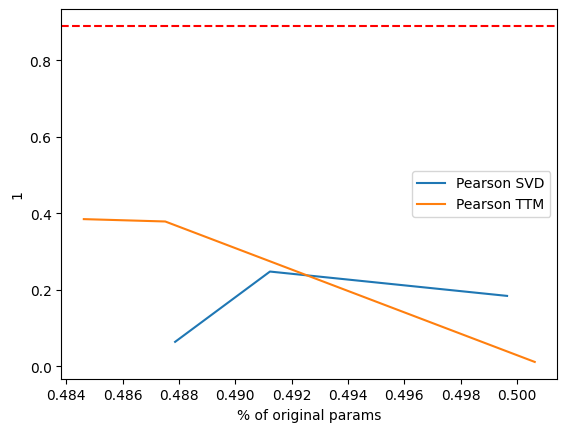

In [ ]:
ax = sns.lineplot(x=0, y=1, data = pd.DataFrame(dd), label='Pearson SVD')
plt.axhline(y=0.89, ls='--', c='red') #non-compressed accuracy
ax.set(xlabel ='% of original params')
sns.lineplot(x=0, y=1, data = pd.DataFrame(dd_ttm), label='Pearson TTM')